In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [18]:
# ADD TIME FEATURES
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  # Make sure the time column is in datetime format
    
    # Extract various time features
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 

    # Transform hour to sine/cosine components
    df['sin_hour'] = np.sin(np.pi * df['hour']/24.)
    #df['cos_hour'] = np.cos(np.pi/2 * df['hour']/24.)

    # Transform month to sine/cosine components
    #df['sin_month'] = np.sin(np.pi * df['month']/12.)
    #df['cos_month'] = np.cos(np.pi/2 * df['month']/12.)

    # Drop the original hour and month columns (optional)
    df = df.drop(columns=['hour'])#, 'month'])
    
    return df

In [19]:
def plot_targets(targets, start_date, end_date):
    # Slice the dataframe based on the provided start and end dates
    targets_subset = targets[(targets['time'] >= start_date) & (targets['time'] <= end_date)]

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.plot(targets_subset['time'], targets_subset['pv_measurement'], label='PV Measurement', color='blue')
    plt.xlabel('Time')
    plt.ylabel('PV Measurement')
    plt.title('PV Measurement Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [20]:
# PREPROCESSING
def preprocessing(targets, observed, estimated, test):
   #bruk lasso regularisering
   #annen learing rate, 0.0001
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Resample observed, estimated, and test data to 1 hour using mean() as aggregator
    # and drop rows where all columns are NaN
    targets = targets.set_index('time').resample('1H').apply(lambda x: x.max()).dropna(how='all').reset_index()
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    test_resampled = test_resampled.drop(columns =[ 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =[ 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'snow_density:kgm3','elevation:m'])
    first_date = targets['time'].min()
    last_date = targets['time'].max()
    
    # Printing the results
    print(f"The dataset starts from {first_date} and ends at {last_date}")

    start_date = '2017-07-01'  # Replace with desired start date
    end_date = '2024-08-30'  # Replace with desired end date
    


   
    # Merge the observed and estimated data
    weather_data = pd.concat([observed_resampled, estimated_resampled])

    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')
    # Add the time-based features
    merged_data = add_time_features(merged_data, 'time')  
    test_resampled = add_time_features(test_resampled, 'date_forecast') 
    if merged_data.empty:
      print(f"merged_data is empty for location ")
    merged_data = merged_data[merged_data['pv_measurement'] != 0]
    
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator for constant stretches
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator to mark stretches. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant stretches
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    print(targets.dtypes)
    # Clean up auxiliary columns
    targets = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    plot_targets(targets, start_date, end_date)
    if observed_resampled.empty:
      print(f"observed_resampled is empty for location ")
    # Drop non-feature columns
    filtered_data = filtered_data.drop(columns=['time', 'date_forecast', 'pv_measurement'])
    
    return filtered_data, test_resampled, is_day_feature, targets

In [21]:
from pycaret.regression import *
def process_location(X, y, location_name):
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']

    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=123,
                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False,
                    #silent=True,  
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')
    # First, create multiple models
    
    #best = compare_models(n_select = 3)
    # Blend models
    #blended = blend_models(best)

    
    # Tune the model
    tuned_lightgbm = tune_model(lightgbm)
    
    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')
    #boost_lightgbm = ensemble_model(bagged_lightgbm, method='Boosting')
    # Finalize the model - this will train it on the complete dataset
    final_model = finalize_model(bagged_lightgbm)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')

    return final_model

In [22]:
help(ensemble_model)

Help on function ensemble_model in module pycaret.regression.functional:

ensemble_model(estimator, method: str = 'Bagging', fold: Union[int, Any, NoneType] = None, n_estimators: int = 10, round: int = 4, choose_better: bool = False, optimize: str = 'R2', fit_kwargs: Union[dict, NoneType] = None, groups: Union[str, Any, NoneType] = None, verbose: bool = True, return_train_score: bool = False) -> Any
    This function ensembles a given estimator. The output of this function is
    a score grid with CV scores by fold. Metrics evaluated during CV can be
    accessed using the ``get_metrics`` function. Custom metrics can be added
    or removed using ``add_metric`` and ``remove_metric`` function.
    
    
    Example
    --------
    >>> from pycaret.datasets import get_data
    >>> boston = get_data('boston')
    >>> from pycaret.regression import *
    >>> exp_name = setup(data = boston,  target = 'medv')
    >>> dt = create_model('dt')
    >>> bagged_dt = ensemble_model(dt, method = 'B

In [23]:
help(blend_models)

Help on function blend_models in module pycaret.regression.functional:

blend_models(estimator_list: list, fold: Union[int, Any, NoneType] = None, round: int = 4, choose_better: bool = False, optimize: str = 'R2', weights: Union[List[float], NoneType] = None, fit_kwargs: Union[dict, NoneType] = None, groups: Union[str, Any, NoneType] = None, verbose: bool = True, return_train_score: bool = False)
    This function trains a Voting Regressor for select models passed in the
    ``estimator_list`` param. The output of this function is a score grid with
    CV scores by fold. Metrics evaluated during CV can be accessed using the
    ``get_metrics`` function. Custom metrics can be added or removed using
    ``add_metric`` and ``remove_metric`` function.
    
    
    Example
    --------
    >>> from pycaret.datasets import get_data
    >>> boston = get_data('boston')
    >>> from pycaret.regression import *
    >>> exp_name = setup(data = boston,  target = 'medv')
    >>> top3 = compare_mod

The dataset starts from 2019-06-02 22:00:00 and ends at 2023-04-30 23:00:00
       pv_measurement
0                0.00
1                0.00
2                0.00
23               0.00
24               0.00
25               0.00
26               0.00
47               0.00
48               0.00
49               0.00
50               0.00
71               0.00
72               0.00
73               0.00
74               0.00
96               0.00
97               0.00
98               0.00
120              0.00
121              0.00
122              0.00
144              0.00
145              0.00
146              0.00
168              0.00
169              0.00
170              0.00
192              0.00
193              0.00
194              0.00
216              0.00
217              0.00
218              0.44
240              0.00
241              0.00
242              0.00
264              0.00
265              0.00
266              0.00
288              0.00
289              0.00


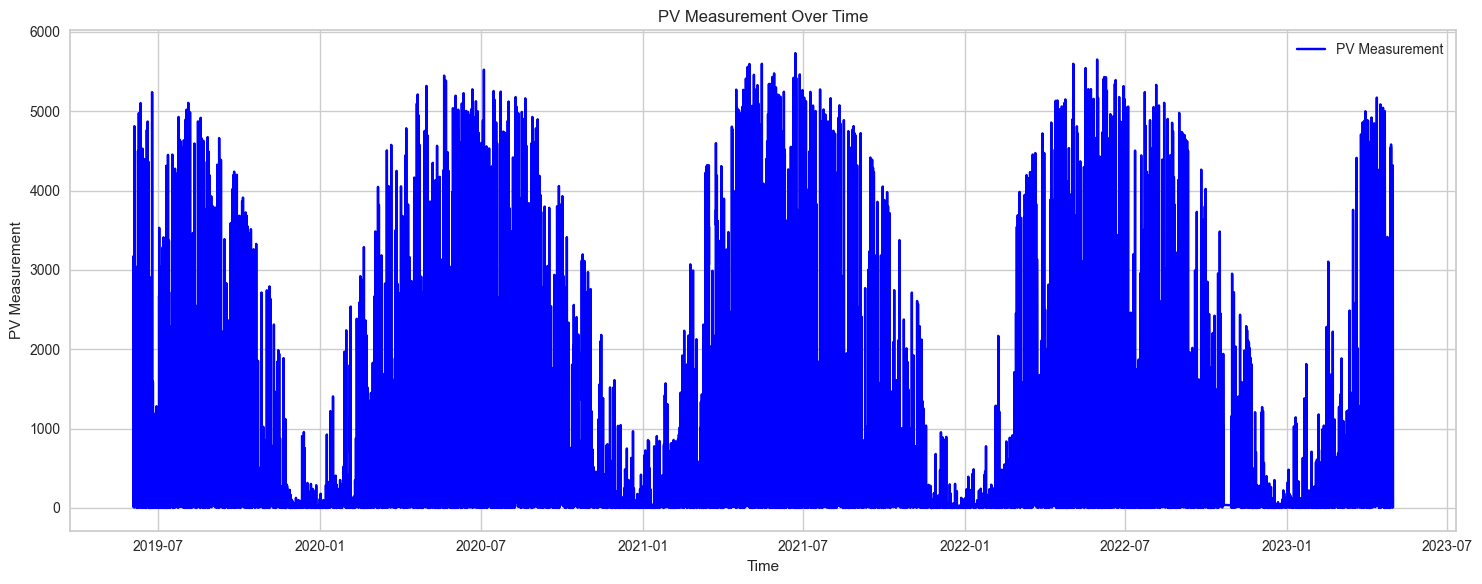

18038 X
18038 y
                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (18038, 49)
4        Transformed data shape  (18038, 61)
5   Transformed train set shape  (12626, 61)
6    Transformed test set shape   (5412, 61)
7              Numeric features           46
8          Categorical features            2
9      Rows with missing values        19.9%
10                   Preprocess         True
11              Imputation type       simple
12           Numeric imputation         mean
13       Categorical imputation         mode
14     Maximum one-hot encoding           25
15              Encoding method         None
16               Fold Generator        KFold
17                  Fold Number           10
18                     CPU Jobs           -1
19                      Use GPU        False
20               Log Experiment        

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     343.9790  289862.6587  538.3889  0.8361  0.8889  3.5925
1     308.2149  255236.4837  505.2093  0.8529  0.8399  2.6000
2     322.9103  277092.1006  526.3954  0.8494  0.8717  2.3371
3     343.1691  306857.3168  553.9470  0.8438  0.8433  2.6908
4     338.9980  293530.7447  541.7848  0.8351  0.8493  2.0498
5     346.4726  311887.6145  558.4690  0.8392  0.8103  1.9423
6     333.9853  293858.7406  542.0874  0.8442  0.8304  1.8241
7     345.6277  326412.3372  571.3251  0.8378  0.8468  2.4565
8     327.7549  287065.6356  535.7851  0.8430  0.8813  2.6946
9     345.5356  325112.4898  570.1864  0.8411  0.8564  2.7846
Mean  335.6647  296691.6122  544.3578  0.8422  0.8518  2.4972
Std    11.9650   20700.9822   19.1352  0.0054  0.0226  0.4856


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     330.8238  270578.7350  520.1718  0.8470  0.9750  5.7495
1     316.5806  260537.8987  510.4291  0.8499  0.9289  3.1546
2     319.0707  267292.6766  517.0036  0.8547  0.9215  2.9623
3     337.7509  303285.5682  550.7137  0.8456  0.9234  3.2224
4     333.2824  290276.1536  538.7728  0.8369  0.8977  2.5617
5     340.5092  300564.5243  548.2377  0.8450  0.8691  2.7018
6     326.1271  284428.2667  533.3182  0.8492  0.8988  3.1987
7     337.6068  305435.7156  552.6624  0.8482  0.9306  3.8224
8     323.7137  277656.9246  526.9316  0.8481  0.9169  3.3221
9     337.2322  311659.4710  558.2647  0.8477  0.9457  3.6097
Mean  330.2697  287171.5934  535.6506  0.8472  0.9208  3.4305
Std     8.0340   16910.9613   15.8138  0.0043  0.0273  0.8517


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     331.1695  269764.9479  519.3890  0.8474  0.8920  3.9528
1     303.5223  249341.0593  499.3406  0.8563  0.8554  2.4664
2     311.5355  260430.2669  510.3237  0.8584  0.8128  1.8554
3     332.2137  290224.3194  538.7247  0.8523  0.8427  2.7190
4     328.1299  283412.9613  532.3654  0.8408  0.8216  2.1047
5     333.6452  294280.7249  542.4765  0.8483  0.7813  2.0779
6     318.7454  276211.5922  525.5584  0.8535  0.8019  2.0061
7     327.3927  297160.3461  545.1242  0.8523  0.8629  2.8914
8     314.8396  265598.5638  515.3626  0.8547  0.8509  2.6098
9     329.6746  308264.6366  555.2158  0.8493  0.8324  2.5653
Mean  323.0868  279468.9418  528.3881  0.8513  0.8354  2.5249
Std     9.7496   17493.2154   16.5822  0.0048  0.0307  0.5759
Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be 

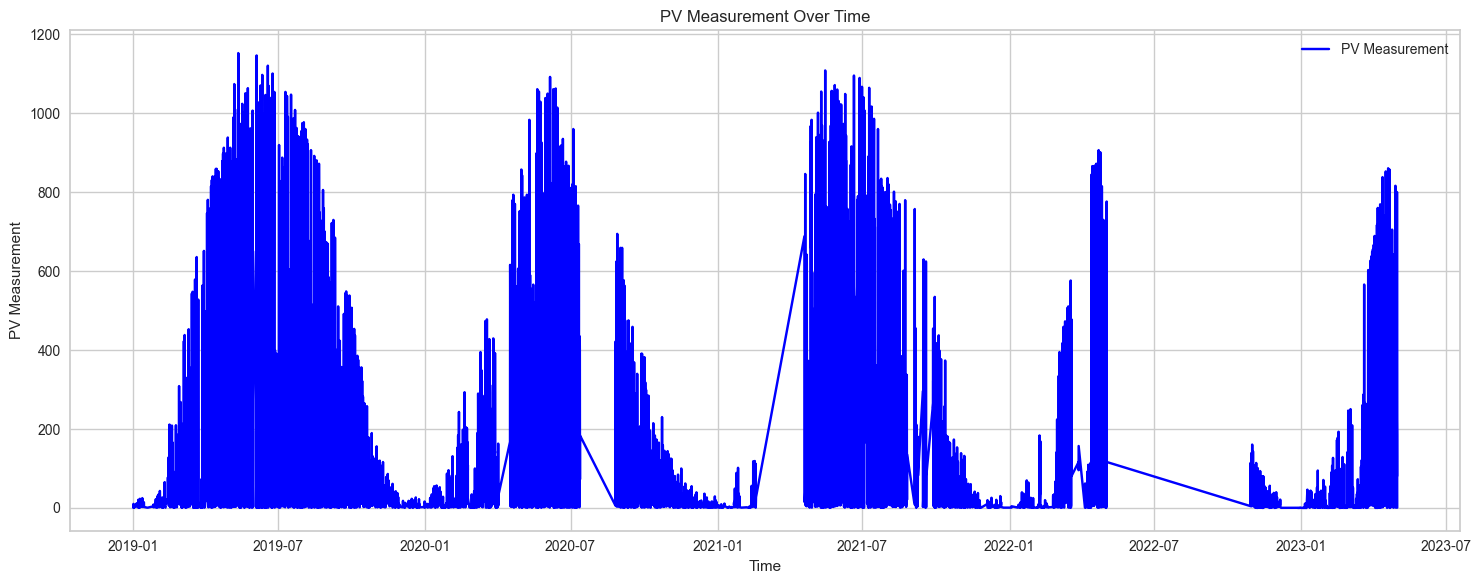

12320 X
12320 y
                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (12320, 49)
4        Transformed data shape  (12320, 61)
5   Transformed train set shape   (8624, 61)
6    Transformed test set shape   (3696, 61)
7              Numeric features           46
8          Categorical features            2
9      Rows with missing values        17.1%
10                   Preprocess         True
11              Imputation type       simple
12           Numeric imputation         mean
13       Categorical imputation         mode
14     Maximum one-hot encoding           25
15              Encoding method         None
16               Fold Generator        KFold
17                  Fold Number           10
18                     CPU Jobs           -1
19                      Use GPU        False
20               Log Experiment        

          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     56.0602  8691.8319  93.2300  0.8824  0.7070   1.4363
1     55.4222  8667.5346  93.0996  0.8734  0.7679  51.6151
2     55.0005  8679.2824  93.1627  0.8805  0.7924   2.0592
3     50.2707  6839.6422  82.7021  0.8911  0.7568   1.8385
4     57.3683  8427.8735  91.8035  0.8592  0.7100   2.0512
5     54.6849  8213.8618  90.6304  0.8876  0.6722   2.1004
6     55.7774  8721.1032  93.3868  0.8660  0.7475   1.8725
7     53.3017  8471.6841  92.0418  0.8706  0.7612   2.0928
8     54.5405  7894.4847  88.8509  0.8745  0.7540   1.8914
9     50.6329  6880.7382  82.9502  0.9027  0.7528   1.8547
Mean  54.3059  8148.8037  90.1858  0.8788  0.7422   6.8812
Std    2.1756   688.9000   3.9149  0.0122  0.0335  14.9125


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE      MAPE
Fold                                                       
0     56.0842  8906.6956  94.3753  0.8795  0.7244    1.2637
1     55.0641  8656.1122  93.0382  0.8736  0.7710  103.1072
2     55.3996  8296.5662  91.0855  0.8857  0.7751    1.9929
3     49.7684  6803.9391  82.4860  0.8917  0.7360    1.7392
4     58.0326  8812.7796  93.8764  0.8528  0.7231    1.7682
5     56.2819  8555.3039  92.4949  0.8829  0.7081    2.5982
6     54.3983  8189.5147  90.4959  0.8742  0.7628    1.4936
7     53.8287  8281.7404  91.0041  0.8735  0.7510    2.1736
8     55.7091  8209.4581  90.6061  0.8695  0.7446    2.1516
9     52.2767  6997.0076  83.6481  0.9011  0.7386    1.6327
Mean  54.6844  8170.9117  90.3110  0.8785  0.7435   11.9921
Std    2.1956   679.1994   3.8505  0.0125  0.0207   30.3739


          MAE        MSE     RMSE      R2   RMSLE     MAPE
Fold                                                      
0     55.7658  8555.0359  92.4934  0.8843  0.6964   1.3981
1     54.7071  8508.6614  92.2424  0.8758  0.7568  74.7854
2     55.4373  8541.4814  92.4201  0.8824  0.7782   2.0329
3     50.1250  6939.5364  83.3039  0.8895  0.7491   1.7467
4     56.6720  8075.2684  89.8625  0.8651  0.7078   1.7151
5     54.1211  7847.6537  88.5870  0.8926  0.6631   1.9416
6     55.2863  8410.6768  91.7097  0.8708  0.7360   1.8041
7     53.7181  8450.7055  91.9277  0.8709  0.7397   2.0341
8     54.2267  7849.0444  88.5948  0.8752  0.7581   2.0114
9     52.1783  7116.7681  84.3609  0.8994  0.7321   1.7826
Mean  54.2238  8029.4832  89.5503  0.8806  0.7317   9.1252
Std    1.8016   563.8658   3.1992  0.0104  0.0323  21.8875
Transformation Pipeline and Model Successfully Saved
float64
date_forecast    datetime64[ns]
is_day:idx              float32
dtype: object
The dataset starts from 2018-12-31 

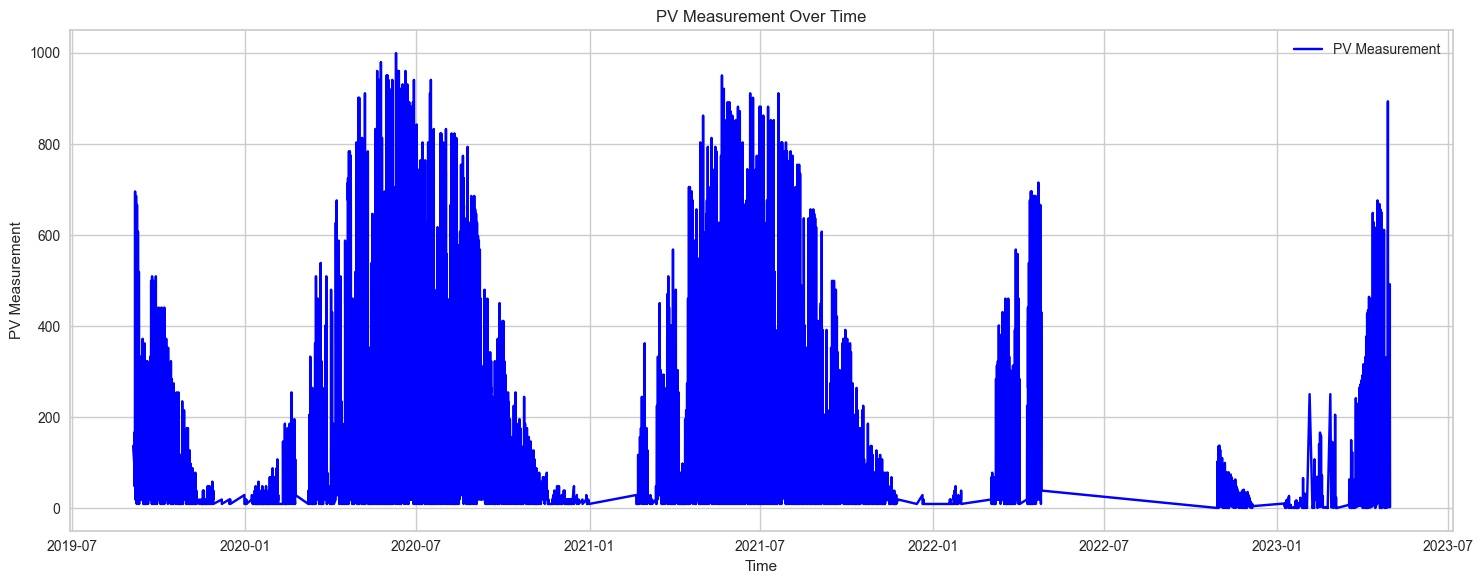

9957 X
9957 y
                    Description       Value
0                    Session id         123
1                        Target      target
2                   Target type  Regression
3           Original data shape  (9957, 49)
4        Transformed data shape  (9957, 61)
5   Transformed train set shape  (6969, 61)
6    Transformed test set shape  (2988, 61)
7              Numeric features          46
8          Categorical features           2
9      Rows with missing values       23.0%
10                   Preprocess        True
11              Imputation type      simple
12           Numeric imputation        mean
13       Categorical imputation        mode
14     Maximum one-hot encoding          25
15              Encoding method        None
16               Fold Generator       KFold
17                  Fold Number          10
18                     CPU Jobs          -1
19                      Use GPU       False
20               Log Experiment       False
21              Ex

          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     53.4032  7323.5186  85.5776  0.8551  0.5554  0.6563
1     46.7411  5573.5999  74.6565  0.8828  0.5703  0.7850
2     48.0566  6452.0043  80.3244  0.8614  0.5621  0.6686
3     48.9973  6546.0547  80.9077  0.8570  0.5502  0.6603
4     49.8565  6214.9878  78.8352  0.8667  0.5828  0.6807
5     47.8256  5680.8910  75.3717  0.8883  0.5565  0.7598
6     49.1532  6583.3318  81.1377  0.8398  0.6054  0.8427
7     48.8604  6258.5010  79.1107  0.8823  0.5423  0.6343
8     51.2300  6757.7506  82.2055  0.8668  0.5465  0.6620
9     47.8803  5578.5545  74.6897  0.8731  0.5898  0.8225
Mean  49.2004  6296.9194  79.2817  0.8673  0.5661  0.7172
Std    1.8265   534.9151   3.3669  0.0141  0.0196  0.0733


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     53.4039  7105.8979  84.2965  0.8594  0.5664  0.6201
1     47.3401  5676.8052  75.3446  0.8807  0.5553  0.7334
2     48.7625  6404.0340  80.0252  0.8624  0.5905  0.6023
3     50.6597  6790.3265  82.4034  0.8517  0.5731  0.6456
4     50.9473  6513.5602  80.7066  0.8603  0.5978  0.6863
5     48.1317  5659.6043  75.2303  0.8887  0.5584  0.7275
6     50.1027  6878.3722  82.9360  0.8326  0.6170  0.8097
7     49.8428  6382.7942  79.8924  0.8800  0.5599  0.6427
8     51.6428  6672.0011  81.6823  0.8685  0.5482  0.6223
9     51.3233  6709.1155  81.9092  0.8474  0.6027  0.7356
Mean  50.2157  6479.2511  80.4427  0.8632  0.5769  0.6826
Std    1.7040   455.0408   2.8689  0.0161  0.0222  0.0637


          MAE        MSE     RMSE      R2   RMSLE    MAPE
Fold                                                     
0     52.7646  7130.1759  84.4404  0.8590  0.5466  0.6584
1     46.2446  5695.8794  75.4710  0.8803  0.5608  0.7639
2     48.3118  6566.6795  81.0351  0.8589  0.5574  0.6668
3     48.4448  6095.4747  78.0735  0.8668  0.5446  0.6534
4     50.7350  6496.3931  80.6002  0.8607  0.5642  0.6835
5     47.9511  5693.5059  75.4553  0.8880  0.5483  0.7398
6     50.3509  6876.5872  82.9252  0.8327  0.6070  0.8726
7     47.5098  5959.3812  77.1970  0.8880  0.5247  0.6029
8     50.9163  6628.1286  81.4133  0.8694  0.5331  0.6382
9     47.9183  5813.0163  76.2431  0.8678  0.5779  0.7519
Mean  49.1147  6295.5222  79.2854  0.8672  0.5565  0.7031
Std    1.8818   486.4774   3.0569  0.0155  0.0223  0.0752
Transformation Pipeline and Model Successfully Saved
float64
date_forecast    datetime64[ns]
is_day:idx              float32
dtype: object


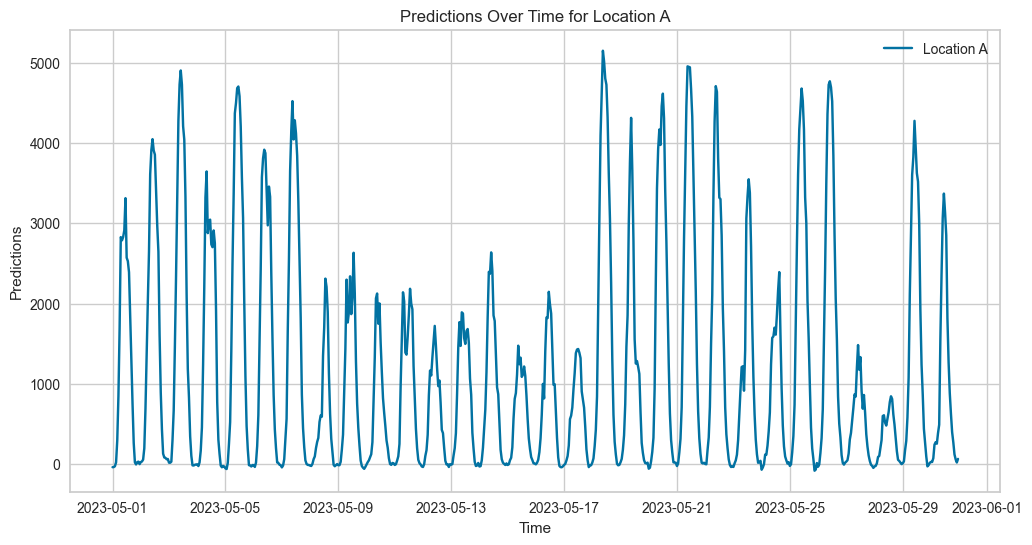

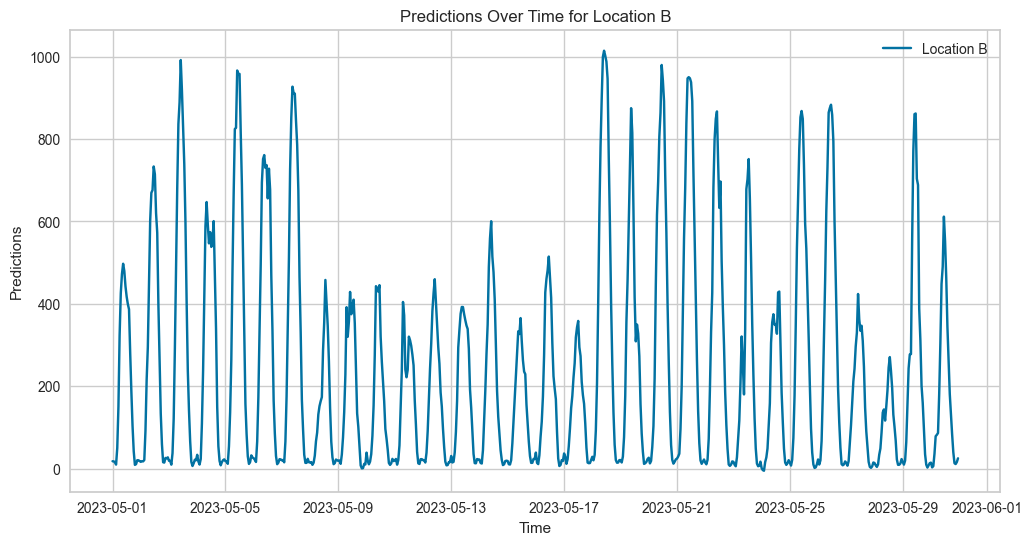

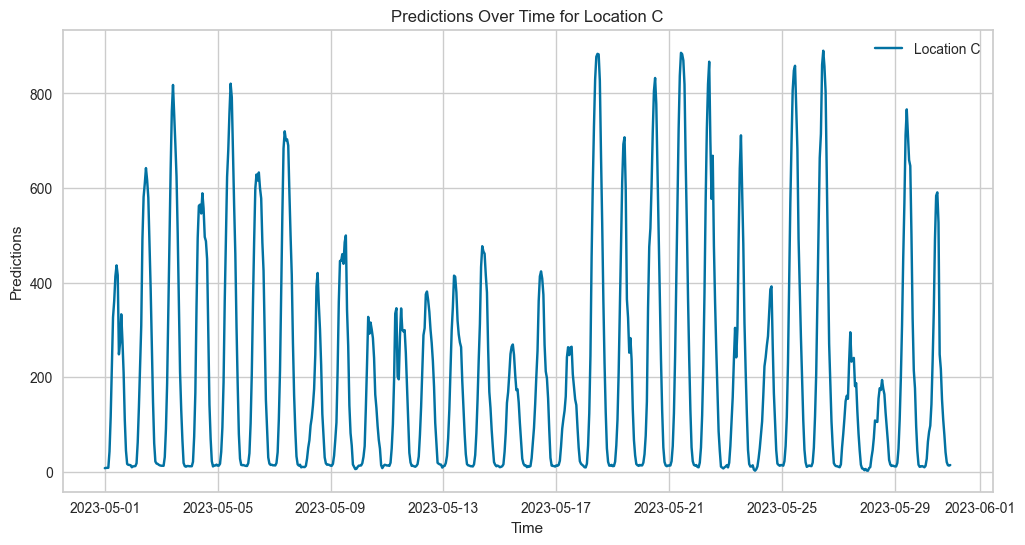

In [24]:
locations = ['A', 'B', 'C']
all_predictions = []
final_df_list = [] 


for loc in locations:
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    '''train_non_zero = train[train['pv_measurement'] != 0]
    if train_non_zero.empty:
        print(f"train_non_zero is empty for location {loc}")

    # Get the timestamps of these rows
    valid_timestamps = train_non_zero['time'].tolist()
    
    # Filter the X_* dataframes based on these timestamps
    X_train_estimated = X_train_estimated[X_train_estimated['date_forecast'].isin(valid_timestamps)]
    X_train_observed = X_train_observed[X_train_observed['date_forecast'].isin(valid_timestamps)]
    #X_test_estimated = X_test_estimated[X_test_estimated['date_forecast'].isin(valid_timestamps)]
    if X_train_estimated.empty:
        print(f"X_train_estimated is empty for location {loc}")'''

    #lage dag og måned feature der man aggregerer opp 
    # Preprocess data
    X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    y_train = targets
    if X_train.empty or len(y_train) == 0:
        print(f"X_train or y_train is empty for location {loc}")

    # Ensure X and y have the same length
    print(len(X_train), 'X')
    print(len(y_train),'y')
    min_length = min(len(X_train), len(y_train))
    X_train, y_train = X_train.iloc[:min_length], y_train[:min_length]
    
    # Process the location data and get the final model
    final_model = process_location(X_train, y_train, loc)
    # Predict on new data
    predictions = predict_model(final_model, data=X_test)
        #print(predictions.columns)
        # Assuming 'predictions' is the output from predict_model
    final_predictions = predictions['prediction_label']
    print(final_predictions.dtypes)
    print(is_day_feature.dtypes)
    # Multiply final predictions with the 'is_day:idx' values
    
    adjusted_final_predictions = final_predictions * is_day_feature['is_day:idx']
    adjusted_final_predictions = np.clip(adjusted_final_predictions, 0, None)
    # Now, 'adjusted_final_predictions' contains the adjusted target values.

        # Store predictions
    all_predictions.append(adjusted_final_predictions)  

        # Prepare dataframe for visualization
    num_predictions = len(predictions)
    timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

    df = pd.DataFrame({
            'time': timestamps,
            'prediction': predictions['prediction_label'],
            'location': loc
        })

    final_df_list.append(df)


# Concatenate all the individual data frames and prepare for plotting
final_df = pd.concat(final_df_list, ignore_index=True)
final_df['time'] = pd.to_datetime(final_df['time'])
final_df.sort_values('time', inplace=True)

# Visualization
for loc in locations:
    # Filter data for each location
    temp_df = final_df[final_df['location'] == loc]
    
    plt.figure(figsize=(12, 6))  # Create a new figure for each location
    plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    plt.show()

# If you need to save the final dataframe without 'time' and 'location' columns, you can do so before plotting
final_df_save = final_df.copy()
final_df_save = final_df_save.drop(columns=['time', 'location'])

In [25]:
print(X_test.shape)


(720, 49)


In [26]:
'''sample_submission = pd.read_csv('sample_submission.csv')
sample_submission
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)'''

final_predictions = np.concatenate(all_predictions)

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
df.to_csv('final_predictions.csv', index=False)